<h1>05-CNN for Multiple chunks of data</h1>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
import glob

from astropy.io import fits
import astropy.coordinates as coords
import astropy.time as at

import sys
import time
import datetime
import itertools
import os

import random
import numpy as np
import subprocess

torch.manual_seed(101101)
random.seed(101101)
np.random.seed(101101)

In [9]:
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [10]:
print(torch.__version__)

1.11.0


In [11]:
print(torch.cuda.is_available())

True


In [12]:
torch.cuda.device_count()

1

In [13]:
print(torch.backends.cudnn.enabled)

True


In [14]:
subprocess.run(['nvcc','--version'])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


CompletedProcess(args=['nvcc', '--version'], returncode=0)

In [15]:
subprocess.run(['conda','list'])

# packages in environment at /ext3/miniconda3/envs/cnnenv:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
alsa-lib                  1.2.8                h166bdaf_0    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
aom                       3.5.0                h27087fc_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
astropy                   5.2.1           py310h0a54255_0    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attr                      2.5.1                h166bdaf_1    conda-forge
attrs                     22.2.0             pyh71513ae_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-fo

CompletedProcess(args=['conda', 'list'], returncode=0)

<h2>Dataset importing</h2>
The question here is how is the data organized in the directory and how can it be imported with the target RV. 

Not the OG data but after the data is saved from the pre processing step.

In [18]:
import pickle

In [19]:
import numpy as np
import h5py as h5

256 by 17 with 16 overlap should be the best size cropping. shit shit shit
0-256 240-496 480-736 720-976 
what is wrong with me im dumb
so dumb dumb dumb

In [20]:
import pickle
def save(filename,model):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        model = pickle.load(input)
        return model

In [21]:
import os.path as path

In [22]:
files1 = glob.glob('/scratch/mdd423/CNN_EPRV/data/peg51_256/*.h5')

crop median and sift through h5s here. then pickle as nd arrays

In [23]:
all_directories = glob.glob('/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/*02-28*')
files = []
for indiv in all_directories:
    files += glob.glob(indiv + '/*.h5')

In [24]:
files

['/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_720-976_1680-1936.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_960-1216_0-256.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_240-496_2880-3136.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_720-976_1440-1696.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_240-496_2160-2416.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_240-496_2640-2896.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_720-976_480-736.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_720-976_960-1216.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_240-496_2400-2656.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28/51Peg_240-496_3120-3376.h5',
 '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/

In [25]:
def h5_to_array(ds,target,location,hdu_num='hdu_1'):
    rvs_stack = []
    bcs_stack = []
    tim_stack = []
    
    img_stack = np.empty((0,3,256,256))
    for visit_name,vist_info in ds['visits'].items():
#         for hdu_num in ds['images'][visit_name].keys():
        img   = np.array(ds['images'][visit_name][hdu_num])
#         
        if np.sum(img.shape) == (256*2):
            
            rvs_stack += [np.double(vist_info.attrs['ESO DRS CCF RVC'])]
            temp_time = at.Time(visit_name.split('HARPS.')[1])
            tim_stack += [temp_time]
            bcs_stack += [target.radial_velocity_correction(obstime=temp_time, location=location).to('km/s').value]
            all_flats = np.empty([0,256,256])
            for key in vist_info.attrs.keys():
                if vist_info.attrs[key] == 'FLAT':
                    temp = np.array(ds['images'][key][hdu_num])[None,...]
                    all_flats = np.append(all_flats, temp,axis=0)
                if vist_info.attrs[key] == 'THAR_THAR':
                    cali = np.array(ds['images'][key][hdu_num])
#                 temp = crop_again(np.stack((img,np.median(all_flats,axis=0),cali)))
            temp = np.stack((img,np.median(all_flats,axis=0),cali))[None,...]
#                 print(temp.shape)
            img_stack = np.append(img_stack,temp,axis=0)
        else:
            print(visit_name)
    return img_stack, np.array(rvs_stack), np.array(bcs_stack), np.array(tim_stack)

ok so now loop through all h5 files convert to nda arrays so they can later be all load back in. append only after saving. load then stack into one array with an index array that refers an image to its chunk and hdu

In [26]:
2148/256

8.390625

<h2>Load in Data</h2>

In [28]:
location = coords.EarthLocation.of_site('La Silla Observatory')
target   = coords.SkyCoord.from_name('51PEG')

iterations = 0
img_stack = np.empty((0,3,256,256))
rvs_stack = np.empty((0))
bcs_stack = np.empty((0))
tim_stack = np.empty((0))
ind_stack = np.empty((0))

start_time = time.time()
total = 2*len(files)
for i,filename in enumerate(files):
    for j,hdu in enumerate(['hdu_1','hdu_2']):
#     filename             = files1[0]

#         ds                   = h5.File(filename,'r')
#         img_stack, rvs_stack, bcs_stack, tim_stack = h5_to_array(ds,target,location,hdu_num=hdu)
        dir_name, tailname = path.split(filename)
        tailname = tailname[:-3]
        imgname = path.join(dir_name, tailname + hdu + '_img.nda')
        rvsname = path.join(dir_name, tailname + hdu + '_rvs.nda')
        bcsname = path.join(dir_name, tailname + hdu + '_bcs.nda')
        timname = path.join(dir_name, tailname + hdu + '_tim.nda')
        
        img_stack = np.append(img_stack, load(imgname),axis=0)
        rvs_stack = np.append(rvs_stack, load(rvsname),axis=0)
        bcs_stack = np.append(bcs_stack, load(bcsname),axis=0)
        tim_stack = np.append(tim_stack, load(timname),axis=0)
        
        ind_stack = np.append(ind_stack, iterations*np.ones(bcs_stack.shape,dtype=int))
        iterations += 1
        
        if (i % 5) == 0:
            load_time = time.time() - start_time
            n_batches = (i*2 + j + 1)
            load_avg  = load_time/n_batches
            remaining = (total - n_batches) * load_avg
            sys.stdout.write('\r[ Loaded: {}/{} | Avg Time: {} | Remaining: {} ]'.format(\
                                                                                       n_batches,total,
                                                                                       load_avg,
                                                                                       str(datetime.timedelta(seconds=remaining))
                                                                                      ))
    

[ Loaded: 162/166 | Avg Time: 4.190519781760227 | Remaining: 0:00:16.762079 ]]

In [29]:
class ND_Dataset(Dataset):
    def __init__(self, imgs,rvs,indices):
        self.img_stack = imgs
        self.rvs_stack = rvs
        self.indices   = indices
        self.type      = torch.Tensor

    def __getitem__(self, index):
        
        return {'img': self.type(self.img_stack[index,...]).double(),
                'rvs': np.double(self.rvs_stack[index]), 
                'indices': self.indices[index]}
    
    
    def __len__(self):
        
        return len(self.rvs_stack)

In [30]:
dataset = ND_Dataset(img_stack,bcs_stack,ind_stack)

In [31]:
len(dataset)

24880

In [32]:
testdata,validdata = torch.utils.data.random_split(dataset,[23880,1000])

In [33]:
batch_size = 64
n_cpu = 2
dataloader = DataLoader(
    testdata,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

validloader = DataLoader(
    validdata,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

In [34]:
import os.path

In [35]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [36]:
print(device)

cuda


In [37]:
lr = 0.001
b1 = 0.9
b2 = 0.999

<h2>Model definition</h2>
Higher stride at higher layers,

In [38]:
class DownSizeNet(nn.Module):
    def __init__(self, in_size, out_size, kernel_size = 3, stride=1, padding=1, leaky_slope=0.2):
        super(DownSizeNet, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size, stride=stride, padding=padding, bias=False).double()]
        layers.append(nn.MaxPool2d(3, stride=stride).double())
        layers.append(nn.LeakyReLU(leaky_slope).double())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        
        return self.model(x)
    
class ChunkNet(nn.Module):
    def __init__(self,s_in,s_h):
        super(ChunkNet, self).__init__()
        self.dense1 = nn.Sequential(nn.Linear(s_in,s_h), nn.ReLU()).double()
        
        self.final = nn.Linear(s_h,1).double()
        
    def forward(self,x):
        d1 = self.dense1(x)
        
        return self.final(d1)

    
class FeatureNet(nn.Module):
    def __init__(self):
        super(FeatureNet, self).__init__()
        self.down1 = DownSizeNet(3,   64,  stride=1)
        self.down2 = DownSizeNet(64,  64,  stride=1, padding=0)
        self.down3 = DownSizeNet(64,  128, stride=1, padding=0, kernel_size=5)
        self.down4 = DownSizeNet(128, 256, stride=2, padding=0, kernel_size=5)
        self.down5 = DownSizeNet(256, 256, stride=2, padding=0, kernel_size=5)
        
        
    def forward(self, x):
        # Propogate noise through fc layer and reshape to img shape
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
#         d6 = self.down6(d5)
        
        return d5
    
class RV_Model(nn.Module):
    def __init__(self,s_c,s_in,s_h,device):
        super(RV_Model, self).__init__()
        self.device = device
        
        self.chunk_models = nn.ModuleList([ChunkNet(s_in,s_h).double().to(device) for i in range(s_c)]).to(device)
        self.feature_model = FeatureNet().double().to(device)
        
    def forward(self,x,indices):
        y1 = self.feature_model(x)
        y1 = torch.flatten(y1,1)
        y2 = torch.empty((y1.shape[0])).to(self.device).double()
        # instead of looping through all indices passed
        # only loop through unique ones so that chunk models
        # can be batch-ran
        for i,index in enumerate(np.unique(indices).astype(int)):
            
#             temp = int()
#             print(y1.index_select(0,torch.where(indices==index)[0].to(self.device)))
#             print(torch.where(indices==index)[0])
#             print(y2.shape)
            y2[torch.where(indices==index)[0]] = self.chunk_models[index.item()](y1.index_select(0,torch.where(indices==index)[0].to(self.device))).squeeze()
            
        return y2

<h2>Defining Fitting Process</h2>
including hyperparameters, the loss function, and the optimization algo

In [39]:
torch.cuda.empty_cache()
# del model, batch

In [40]:
s_c  = int(np.max(ind_stack))
s_in = 43264
s_h  = 64
s_out= 64
model     = RV_Model(s_c,s_in,s_h,device).to(device)
mse_loss  = torch.nn.MSELoss().double()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))

In [41]:
thing = 0
for parameter in model.chunk_models.parameters():
    thing += np.product(parameter.shape)
    
thing2 = 0
for parameter in model.feature_model.parameters():
    thing2 += np.product(parameter.shape)
print('dense',thing/165)
print('conv   ' ,thing2)
print('dcr', thing/165/thing2)

dense 2769025.0
conv    2700992
dcr 1.025188153093382


check which devices each of these parameters are located on run.

In [42]:
valiter = itertools.cycle(validloader)
start_time = time.time()
batch = next(valiter)
y = model(batch['img'].to(device),batch['indices']).squeeze()
print('batch time: ', time.time() - start_time)

batch time:  11.489345073699951


In [43]:
unq_indices = np.unique(batch['indices']).astype(int)
print(batch['indices'])
for i,index in enumerate(unq_indices):
    print(torch.where(batch['indices']==index))

tensor([14., 13., 14.,  5.,  5.,  8., 14., 14., 13., 14., 12.,  4., 11., 14.,
        10., 10.,  9., 11.,  5.,  9.,  4., 14., 11., 10., 12., 12.,  7.,  4.,
        13.,  3., 14.,  1.,  5., 10., 11.,  3.,  1., 12., 14., 12.,  6., 13.,
         8., 11.,  7.,  8., 14.,  8., 12., 13., 14.,  6., 13., 13., 14.,  9.,
         7.,  3., 11., 11.,  8., 12., 13., 11.], dtype=torch.float64)
(tensor([31, 36]),)
(tensor([29, 35, 57]),)
(tensor([11, 20, 27]),)
(tensor([ 3,  4, 18, 32]),)
(tensor([40, 51]),)
(tensor([26, 44, 56]),)
(tensor([ 5, 42, 45, 47, 60]),)
(tensor([16, 19, 55]),)
(tensor([14, 15, 23, 33]),)
(tensor([12, 17, 22, 34, 43, 58, 59, 63]),)
(tensor([10, 24, 25, 37, 39, 48, 61]),)
(tensor([ 1,  8, 28, 41, 49, 52, 53, 62]),)
(tensor([ 0,  2,  6,  7,  9, 13, 21, 30, 38, 46, 50, 54]),)


In [44]:
np.sqrt(43264/256)

13.0

In [45]:
print(batch['img'].shape,y.shape,y.device)

torch.Size([64, 3, 256, 256]) torch.Size([64]) cuda:0


In [46]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)

In [47]:
print((r-a)/1e6, '/', t/1e6, '~Mb',r/1e6)

29.118464 / 85039.775744 ~Mb 39780.876288


In [48]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   37910 MB |   37932 MB |   37932 MB |   22620 KB |
|       from large pool |   37904 MB |   37926 MB |   37926 MB |   22528 KB |
|       from small pool |       5 MB |       5 MB |       5 MB |      92 KB |
|---------------------------------------------------------------------------|
| Active memory         |   37910 MB |   37932 MB |   37932 MB |   22620 KB |
|       from large pool |   37904 MB |   37926 MB |   37926 MB |

<h2>Training Step</h2>
the working step!

In [49]:
import subprocess
subprocess.run(['nvidia-smi'])

Fri Mar 17 09:52:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:E3:00.0 Off |                    0 |
| N/A   33C    P0    81W / 500W |  39647MiB / 81920MiB |     21%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

CompletedProcess(args=['nvidia-smi'], returncode=0)

In [50]:
2*len(dataset)/400

124.4

In [51]:
n_epochs = 10
train_loss = []
valid_loss = []

valiter = itertools.cycle(validloader)
b_avg = 0.0
e_avg = 0.0

start_t = time.time()

directory, tail = path.split(filename)
for j,epoch in enumerate(range(n_epochs)):
    
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()

        y    = model(batch['img'].to(device),batch['indices']).squeeze()

        loss = mse_loss(y.double(),batch['rvs'].to(device).double())
        loss.backward()
        optimizer.step()
        b_time = time.time() - start_t
        b_avg  = b_time / (i + 1 + (j * len(dataloader)))
        
        if (i % 10) == 0:
            # Validation checkpoint every 5 batches
            valbatch = next(valiter)
            model.eval()
            with torch.no_grad():
                y     = model(     valbatch['img'].to(device),valbatch['indices']).squeeze()

                vloss = mse_loss(y,valbatch['rvs'].to(device).double())
                
                r_time = b_avg * ((len(dataloader) * n_epochs) - (i + 1 + (j * len(dataloader))))
                sys.stdout.write(
                        "\r[Epoch %d/%d | Batch %d/%d | TL: %f | VL: %f | BT: %s | ET: %s | RT: %s]"
                        % (
                            epoch,
                            n_epochs,
                            i,
                            len(dataloader),
                            loss.item(),
                            vloss.item(),
                            str(datetime.timedelta(seconds=b_avg)),
                            str(datetime.timedelta(seconds=e_avg)),
                            str(datetime.timedelta(seconds=r_time))
                        )  
                )
#             subprocess.run(['nvidia-smi'])
            
            model.train()
            
    train_loss.append(loss.item())
    valid_loss.append(vloss.item())
    if (j % 1) == 0:
        # Saving checkpoint every 10 epoches
        modelpath = '/scratch/mdd423/CNN_EPRV/models/rv_model_multi_{}_{}_{}_bcs.model'.format(tail[:-3],j,n_epochs)
        torch.save(model.state_dict(), modelpath)
    e_time = time.time() - start_t
    e_avg  = e_time/(j + 1)
train_loss = np.array(train_loss)
valid_loss = np.array(valid_loss)

[Epoch 9/10 | Batch 370/374 | TL: 257.750620 | VL: 228.865650 | BT: 0:00:05.505661 | ET: 0:34:19.598020 | RT: 0:00:16.516983]]]]

5 times parameters of dense matrices as convolutional matrix

In [52]:
modelpath = '/scratch/mdd423/CNN_EPRV/models/rv_model_multi_{}_{}_bcs.model'.format(j,n_epochs)
torch.save(model.state_dict(), modelpath)

In [53]:
tlname = path.join(dir_name, tailname + '_multi_tl_bcs.nda')
vlname = path.join(dir_name, tailname + '_multi_vl_bcs.nda')
np.save(tlname,train_loss)
np.save(vlname,valid_loss)

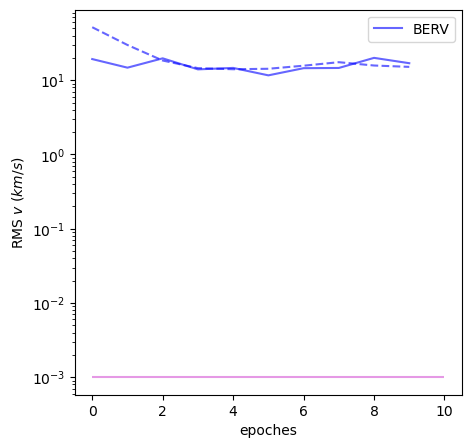

In [55]:
fig, ax = plt.subplots(1,figsize=(5,5))

plt.plot(np.sqrt(train_loss),'-b',alpha=0.6,label='BERV')
plt.plot(np.sqrt(valid_loss),'--b',alpha=0.6)
# plt.ylim(0,50)
plt.legend()
ax.set_ylabel('RMS $v$ ($km/s$)')
ax.set_xlabel('epoches')
plt.hlines(1e-3,0,len(train_loss),'m',alpha=0.4)
plt.yscale('log')
# plt.savefig(path.join(dir_name, tailname + '_loss_bcs-rvs.png'))
plt.show()